In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


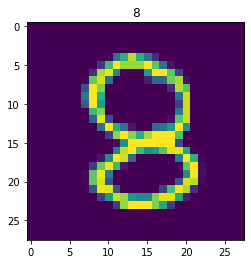

In [ ]:
# Load and read data from .npz file
with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER
# 2. INDEX: COLOR CHANNEL
# 3/4. INDEX: PIXEL VALUE
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

# Data Visulisation
plt.imshow(data_x[0, 0])
plt.title(data_y[0])
plt.show()

# Data Processing

In [ ]:
# set training and validation set and test_set lengths
data_len = data_x.shape[0]
train_len, val_len = int(data_len * 0.8), int(data_len * 0.95)
#random indices data 
indices = np.random.permutation(data_x.shape[0])
train_idx, val_idx, test_idx = indices[:train_len], indices[train_len:val_len], indices[val_len:]
# make train, val and test set
train_x, train_y = data_x[:train_len], data_y[:train_len]
val_x, val_y = data_x[train_len:val_len], data_y[train_len:val_len]
intest_x, intest_y = data_x[val_len:], data_y[val_len:]


# Mean

Mean subtraction is the most common form of preprocessing. It involves subtracting the mean across every individual feature in the data

#Normalisation
in case of images, the relative scales of pixels are already approximately equal (and in range from 0 to 255), so it is not strictly necessary to perform this additional preprocessing step.

https://cs231n.github.io/neural-networks-2/

#Weight initialstion
https://arxiv.org/abs/1502.01852

In [ ]:
#data_processing
train_x = train_x / 255
val_x = val_x / 255

#weight initialisation if necessary
#n = 28 * 28
#w = np.random.randn(n) * np.sqrt(2.0/n)

# Data set up for pytorch

In [ ]:
# Data processing for pytorch
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_xt, train_yt, val_xt, val_yt, intest_xt, intest_yt = map(
    torch.tensor, (train_x, train_y, val_x, val_y, intest_x, intest_y)
)

bs = 64  # batch size
train_ds = TensorDataset(train_xt, train_yt)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(val_xt, val_yt)
valid_dl = DataLoader(valid_ds, batch_size=50)

# Define a Neural Network

# with Linear layers : DO NOT GIVE GOOD RESULTS



In [1]:
import torch.nn as nn

In [ ]:
# Trial with linear layers : NOT GOOD RESULTS
# Style 1
class Net(nn.Module):
   def __init__(self):
     super(Net, self).__init__()
     self.layer1 = nn.Linear(28*28, 512)
     self.layer2 = nn.Linear(in_features=512, out_features=256)
     self.layer3 = nn.Linear(in_features=256, out_features=64)
     self.layer4 = nn.Linear(in_features=64, out_features=10)

   def forward(self,x):
     x = x.view(x.shape[0],-1)  #input X (64,1,28,28) reshape (64, 28*28) 
     out = self.layer1(x) #(64, 28*28) and (28*28, 512) gives (64, 512)
     out1 = nn.functional.relu(out)

     out2 = self.layer2(out1) #(64, 512) and (512, 512) gives (64, 512)
     out2 = nn.functional.relu(out2) 

     out3 = self.layer3(out2) #(64, 512) and (512,10) gives (64, 10)
     out3 = nn.functional.relu(out3) 

     out4 = self.layer4(out3) #(64, 512) and (512,10) gives (64, 10)
     out4 = nn.functional.relu(out4) 

     return out1, out2, out3, out4

net = Net()
print(net)

Net(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)


# with CONVOLUTIONAL layers : GIVES FAR BETTER RESULTS

In [ ]:
# Sequential way Conv : GOOD RESULTS
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
            #layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, 
                      stride=1,padding=0 ),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2)
                      )
        #Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=5, stride=1,padding=0),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2)
                      )

        #layer fc1
        self.fc1 = nn.Linear(in_features=4*4*64, out_features=64)
        #layer fc2
        self.fc2 = nn.Linear(in_features=64, out_features=10)
        

    def forward(self, x):
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out2 = out2.view(out2.shape[0],-1)
        out3 = self.fc1(out2)
        out4 = self.fc2(out3)
        return out1, out2, out3, out4
net = Net()
print(net)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


# Define a Loss function and optimizer

In [ ]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network

model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and .eval() will do it for you. In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation.

model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).

model.train() tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly. it just set the mode.

In [ ]:
from torch import nn
training_size = len(train_dl.dataset)
loss_epoch_trn_list, loss_epoch_val_list = [], [] # loss storage lists

for epoch in range(20):
  running_trn_loss, running_batch_trn_loss = 0.0 , 0.0
  print(f"\nEpoch {epoch+1}\n-------------------------------")
  
  # TRAINING
  net.train()

  for batch_num, (input, label) in enumerate(train_dl):
    #input, label = input.to(device), label.to(device)

    # prediction
    pred = net(input) 
    loss = criterion(pred[3], label) #evalute loss
    
    # backpropogation 
    loss.backward() 
    optimizer.step()
    optimizer.zero_grad() # zeroes the parameter gradients
    
    # statistics
    running_trn_loss += loss.item()
    running_batch_trn_loss += loss.item() 
         
    if batch_num % 25 == 24:
      current_index = (batch_num+1) * bs
      print(f"loss: {running_batch_trn_loss/(50 * bs) :>7f}  [{current_index:>5d}/{training_size:>5d}]")
      running_batch_trn_loss = 0
  
  # cummulative training loss after each epoch
  epoch_mean_trn_loss = running_trn_loss / training_size
  loss_epoch_trn_list.append(epoch_mean_trn_loss)
  print(f"Training avg loss: {loss_epoch_trn_list[-1]:>7f}")
  
  
  # VALIDATION
  net.eval()
  
  validation_size = len(valid_dl.dataset)
  running_val_loss, correct_prediction = 0, 0
  with torch.no_grad():
    for X, y in valid_dl:
      val_pred = net(X)
      val_loss = criterion(val_pred[3], y)
      running_val_loss += val_loss.item()
      correct_prediction += (y == torch.argmax(val_pred[3],dim=1)).float().sum().item()
  
  val_accuracy = correct_prediction / validation_size * 100
  epoch_mean_val_loss = running_val_loss / validation_size
  loss_epoch_val_list.append(epoch_mean_val_loss) # append to list
  print(f"Validation Accuracy: {(val_accuracy):>0.1f}%, validation avg loss: {loss_epoch_val_list[-1]:>8f}")

  #saving model for minimum validation loss
  if loss_epoch_val_list[-1] <= min(loss_epoch_val_list):
    print("model saved\n")
    torch.save(net, './best_mnist_net.pth')




Epoch 1
-------------------------------
loss: 0.012144  [ 1600/16000]
loss: 0.004359  [ 3200/16000]
loss: 0.002488  [ 4800/16000]
loss: 0.002059  [ 6400/16000]
loss: 0.001774  [ 8000/16000]
loss: 0.001546  [ 9600/16000]
loss: 0.001480  [11200/16000]
loss: 0.001084  [12800/16000]
loss: 0.001010  [14400/16000]
loss: 0.000926  [16000/16000]
Training avg loss: 0.005774
Validation Accuracy: 96.5%, validation avg loss: 0.002190
model saved


Epoch 2
-------------------------------
loss: 0.000815  [ 1600/16000]
loss: 0.000796  [ 3200/16000]
loss: 0.000766  [ 4800/16000]
loss: 0.000761  [ 6400/16000]
loss: 0.000747  [ 8000/16000]
loss: 0.000894  [ 9600/16000]
loss: 0.000597  [11200/16000]
loss: 0.000730  [12800/16000]
loss: 0.000628  [14400/16000]
loss: 0.000789  [16000/16000]
Training avg loss: 0.001504
Validation Accuracy: 97.1%, validation avg loss: 0.001890
model saved


Epoch 3
-------------------------------
loss: 0.000543  [ 1600/16000]
loss: 0.000528  [ 3200/16000]
loss: 0.000513  [ 4

# validation vs test error : Visualisation

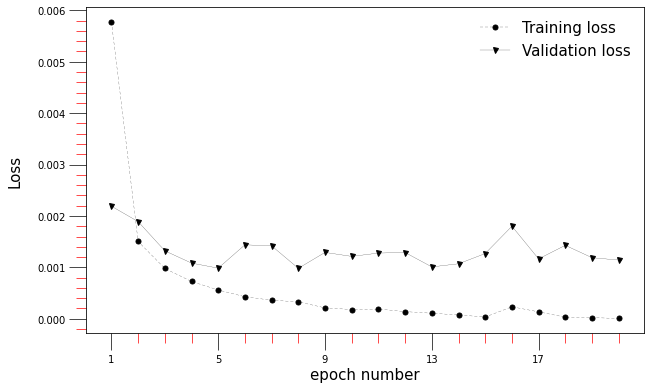

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
fig,ax = plt.subplots(figsize=(10, 6))
x_points = np.arange(1, epoch+2, 1 )
x_points_ = np.arange(1, epoch+3, 4 )
ax.set_xticks(x_points_)
ax.set_xlabel('epoch number',fontsize=15, labelpad =3)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', width=0.7,length=17,direction="out" , labelleft=True )
ax.tick_params(which='minor', width=0.7, length=10, color='r', direction="out")
ax.set_ylabel('Loss',fontsize=15, labelpad=15)
ax.plot(x_points, loss_epoch_trn_list , color = 'black', marker='o', markersize=5 , linestyle='dashed', dashes=(15, 10),linewidth=0.2) 
ax.plot(x_points, loss_epoch_val_list , color = 'black', marker='v', markersize=5 , linestyle='solid', linewidth=0.2) 
ax.legend(['Training loss','Validation loss' ], loc='best', fontsize=15, frameon=False)
plt.show()

# Load the saved model

In [ ]:
#load model and continue training
PATH = './best_mnist_net.pth'
our_saved_model = torch.load(PATH)
#for training
#new_model.train()
#Todo make train function and run training
#for validation
#new_model.eval()
#Todo make validate function and run validation

# Generalisation in the test set

In [ ]:
intest_x = intest_x / 255
intest_xt = torch.tensor(intest_x)

In [ ]:
test_size = intest_xt.shape[0]
our_saved_model.eval()
with torch.no_grad():
  test_predi = our_saved_model(intest_xt)
  correct_pred = intest_yt.eq(torch.argmax(test_predi[3],dim=1))
  correct_pred = correct_pred.float().sum().item()
  nd_test_prediction = torch.argmax(test_predi[3],dim=1).numpy()
  test_accuracy = correct_pred / test_size * 100
  print(f"Testset Accuracy: {(test_accuracy):>0.1f}%")

Testset Accuracy: 98.6%


#access parameters of a layer

In [ ]:
#parameters of a layer
weights_4 = net.layer4.weight
bias_4 = net.layer4.bias
print(weights_4.shape)
print(bias_4.shape)

# model parameters

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
layer1.weight 	 torch.Size([512, 784])
layer1.bias 	 torch.Size([512])
layer2.weight 	 torch.Size([256, 512])
layer2.bias 	 torch.Size([256])
layer3.weight 	 torch.Size([64, 256])
layer3.bias 	 torch.Size([64])
layer4.weight 	 torch.Size([10, 64])
layer4.bias 	 torch.Size([10])


# Visualize feature map

https://discuss.pytorch.org/t/visualize-feature-map/29597

detach function

http://www.bnikolic.co.uk/blog/pytorch-detach.html

1. detach() detaches the output from the computationnal graph. So no gradient will be backproped along this variable.
torch.no_grad says that no operation should build the graph.

2. The difference is that one refers to only a given variable on which it’s called. The other affects all operations taking place within the with statement.

3. torch.no_grad can be used in eval phase in general.
 detach() on the other hand should not be used if you’re doing classic cnn like architectures. It is usually used for more tricky operations. detach() is useful when you want to compute something that you can’t / don’t want to differentiate. Like for example if you’re computing some indices from the output of the network and then want to use that to index a tensor. The indexing operation is not differentiable wrt the indices. So you should detach() the indices before providing them.

In [ ]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = dataset[0]
data.unsqueeze_(0)
output = model(data)

act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])


for name, layer in model_1.named_modules():
    layer.register_forward_hook(get_activation(name))

x = torch.randn(1, 10)
output = model(x)
for key in activation:
    print(activation[key])

torch.Size([10, 64])
torch.Size([10])


In [ ]:
# Visualize conv filter
kernels = model.conv1.weight.detach()
fig, axarr = plt.subplots(kernels.size(0))
for idx in range(kernels.size(0)):
    axarr[idx].imshow(kernels[idx].squeeze())

# paramters (weights and bias) of each layer IF sequential saved
for example:
            
            self.linear_relu_stack = 
            nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()

In [ ]:
layer_1 = net.linear_relu_stack[0]
print(layer_1.bias.shape)
print(layer_1.weight.shape)

In [ ]:
for name, layer in model_1.named_modules():
    layer.register_forward_hook(get_activation(name))

x = torch.randn(1, 10)
output = model(x)
for key in activation:
    print(activation[key])

# Clean Code:
Redefining network in Functional way: An example

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  '''
  Training phase of the network

  i/p: 
  dataloader: training data loader
  model: nueral network model object
  loss_fn: error function criteria
  optimizer: optimizer method

  returns:
  running_trn_loss: Training avg training loss of each epoch
  '''
  for batch_num, data in enumerate(train_dl):
    #input, label = input.to(device), label.to(device)
    input, label = data # size [64,1,128,128], [64]
    
    # prediction
    pred = model(input) 
    loss = criterion(pred[3], label) #evalute loss, pred[] 
       
    # backpropogation 
    loss.backward() 
    optimizer.step()
    optimizer.zero_grad() # zeroes the parameter gradients
    
    # statistics
    running_trn_loss += loss.item()
    running_batch_trn_loss += loss.item() 
         
    if batch_num % 25 == 24:
      current_index = (batch_num+1) * bs
      print(f"loss: {running_batch_trn_loss/(50 * bs) :>7f}  [{current_index:>5d}/{training_size:>5d}]")
      running_batch_trn_loss = 0
  epoch_mean_trn_loss = running_trn_loss / training_size
  return epoch_mean_trn_loss
  
loss_epoch_trn_list.append(epoch_mean_trn_loss)
print(f"Training avg loss: {loss_epoch_trn_list[-1]:>7f}")


In [ ]:
def validation(dataloader, model, loss_fn):
  '''
  Validation phase of the network

  i/p: 
  dataloader: validation data loader
  model: nueral network model object
  loss_fn: error function criteria

  returns:
  running_trn_loss: Cummulative validation loss of each epoch
  '''

  validation_size = len(dataloader.dataset)
  running_val_loss, correct_prediction = 0, 0
  
  net.eval()
  with torch.no_grad():
    for X, y in dataloader:
      val_pred = model(X)
      val_loss = loss_fn(val_pred[3], y)
      running_val_loss += val_loss.item()
      correct_prediction += (y == torch.argmax(val_pred[3],dim=1)).float().sum().item()
  
  val_accuracy = correct_prediction / validation_size * 100
  epoch_mean_val_loss = running_val_loss / validation_size
  loss_epoch_val_list.append(epoch_mean_val_loss) # append to list
  print(f"Validation Accuracy: {(val_accuracy):>0.1f}%, validation avg loss: {loss_epoch_val_list[-1]:>8f} \n")

  #saving model for minimum validation loss
  if loss_epoch_val_list[-1] <= min(loss_epoch_val_list):
    print("model saved at", epoch)
    torch.save(net, './best_mnist_net.pth')

In [ ]:
#save model
model_1 = torch.load('net.pth')

# Cleaner code : pytorch website

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [ ]:
#Dataset is 160000 while Dataset.dataloader is and iterable of 16000/batch_size
train_dl.dataset
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, net, criterion, optimizer)
    test(valid_dl, net, criterion )
print("Done!")

Epoch 1
-------------------------------
loss: 18.486181  [    0/16000]
loss: 18.826414  [ 6400/16000]
loss: 19.768499  [12800/16000]
Test Error: 
 Accuracy: 1.5%, Avg loss: 0.399434 

Epoch 2
-------------------------------
loss: 21.409977  [    0/16000]
loss: 20.177744  [ 6400/16000]
loss: 20.319199  [12800/16000]
Test Error: 
 Accuracy: 1.5%, Avg loss: 0.399434 

Epoch 3
-------------------------------
loss: 20.475042  [    0/16000]
loss: 18.319780  [ 6400/16000]
loss: 20.737833  [12800/16000]
Test Error: 
 Accuracy: 1.5%, Avg loss: 0.399434 

Epoch 4
-------------------------------
loss: 19.328180  [    0/16000]
loss: 18.103186  [ 6400/16000]
loss: 19.199057  [12800/16000]
Test Error: 
 Accuracy: 1.5%, Avg loss: 0.399434 

Epoch 5
-------------------------------
loss: 21.236141  [    0/16000]
loss: 20.639696  [ 6400/16000]
loss: 19.110626  [12800/16000]
Test Error: 
 Accuracy: 1.5%, Avg loss: 0.399434 

Done!


In [ ]:
#code for assignment submission
import numpy as np

prediction = nd_test_prediction # THAT'S YOUR JOB

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 1000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('./prediction.npy', prediction)